In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# for different models
import statsmodels.formula.api as smf

#warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df =pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


### 1. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [4]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


<AxesSubplot:>

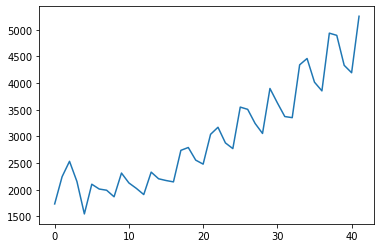

In [5]:
df.Sales.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

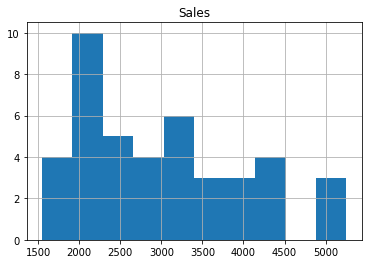

In [6]:
# checking the normality of the data 

df.hist('Sales')
plt.show

Text(0.5, 1.0, 'Density Plot')

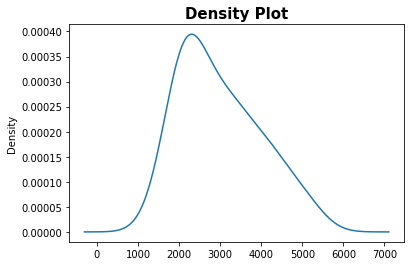

In [7]:
df['Sales'].plot(kind = 'kde')
plt.title("Density Plot",size = 15, weight = 'bold')

In [8]:
df['Quarters'] = 0
df['Year'] = 0
for i in range(42):
    p = df['Quarter'][i]
    df['Quarters'][i] = p[0:2]
    df['Year'][i] = p[3:5]

In [9]:
# Check for dummies
Quarters_Dummies =pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat([df,Quarters_Dummies], axis = 1)

In [10]:
df1["t"]=np.arange(1,43)

df1["t_squared"] = df1["t"]*df1["t"]

df1["Log_Sales"]=np.log(df1["Sales"])

In [11]:
df1.columns

Index(['Quarter', 'Sales', 'Quarters', 'Year', 'Q1', 'Q2', 'Q3', 'Q4', 't',
       't_squared', 'Log_Sales'],
      dtype='object')

<AxesSubplot:xlabel='Quarters', ylabel='Year'>

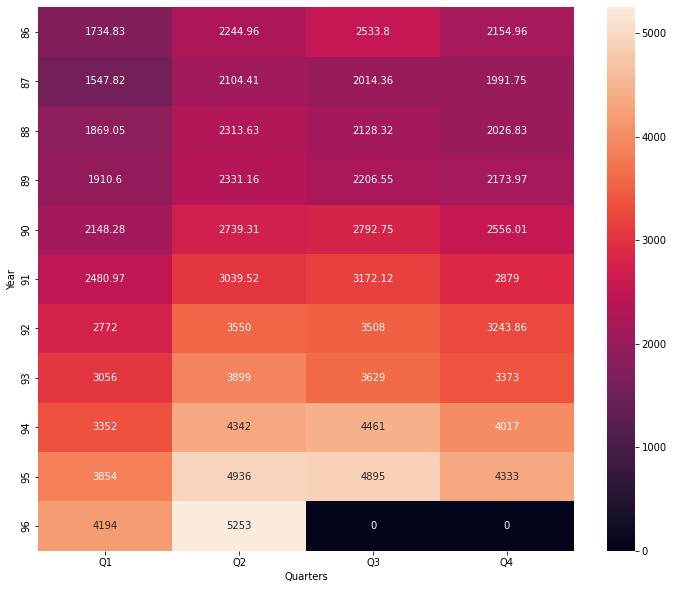

In [12]:
# Visualize the data

plt.figure(figsize=(12,10))
plot_month_y = pd.pivot_table(data = df, values='Sales',index='Year', columns='Quarters', aggfunc='mean',fill_value=0)
sns.heatmap(plot_month_y, annot= True, fmt = 'g')

<AxesSubplot:xlabel='Year', ylabel='Sales'>

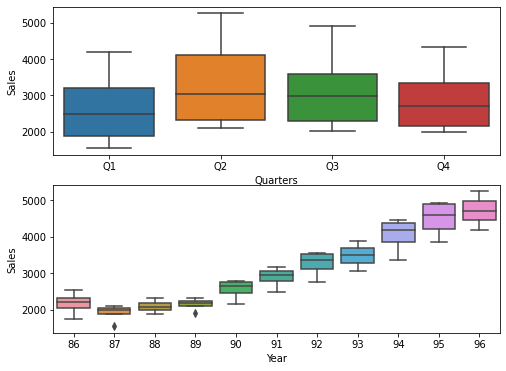

In [13]:
# Boxplot
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="Quarters",y="Sales",data=df1)
plt.subplot(212)
sns.boxplot(x="Year",y="Sales",data=df1)

### 2. Building the models

#### 2.1 Split data in Train and Test 

In [14]:
Train = df1.head(38)
Test =  df1.tail(4)

#### 2.2  --> Linear Model

In [15]:

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

591.553295722396

#### 2.3 --> Exponential Model

In [16]:
Exp = smf.ols('Log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

466.2479731067161

#### 2.4 --> Quadratic Model

In [17]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[['t','t_squared']]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

475.56183518315595

#### 2.5 --> Additive seasonality

In [18]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea =pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1860.0238154547274

#### 2.6 --> Additive Seasonality Quadratic

In [19]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad =np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

301.73800719349407

#### 2.7 --> Multiplicative Seasonality

In [20]:
Mul_sea = smf.ols('Log_Sales~Q1+Q2+Q3', data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1963.3896400779715

#### 2.8 --> Multiplicative Additive Seasonality

In [21]:
Mul_Add_sea = smf.ols('Log_Sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

225.5243904981748

### --> Tabulating the rmse values

In [22]:
data = {'MODEL':pd.Series(['rmse_Linear','rmse_Exp','rmse_Quad','rmse_Add_sea','rmse_Add_sea_quad','rmse_Mult_sea','rmse_Mult_Add_sea']),'RMSE_Values':pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse = pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_Add_sea,225.524390
4,rmse_Add_sea_quad,301.738007
1,rmse_Exp,466.247973
2,rmse_Quad,475.561835
0,rmse_Linear,591.553296
3,rmse_Add_sea,1860.023815
5,rmse_Mult_sea,1963.389640


### Conclusion:
### From the above rmse values --> (rmse_Mult_Add_sea = 225.524) is the best fit model

### 3. Forecast for next 4 Quarters

In [23]:
data = [['Q3_96','Q3'],['Q4_96','Q4'],['Q1_97','Q1'],['Q2_97','Q2']]
print(data)
forecast = pd.DataFrame(data, columns = ['Quarter','quarter'])
forecast

[['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'], ['Q2_97', 'Q2']]


,Quarter,quarter
0,Q3_96,Q3
1,Q4_96,Q4
2,Q1_97,Q1
3,Q2_97,Q2


In [24]:
# Create dummies and T and T-Squared columnns

dummies  = pd.DataFrame(pd.get_dummies(forecast['quarter']))
forecast1 = pd.concat([forecast, dummies], axis =1)
print('After dummy\n', forecast1.head())

forecast1['t'] = np.arange(1,5)
forecast1['t_squared'] = forecast1['t']* forecast1['t']
print('\nAfter T and T-Squared\n', forecast1.head())

After dummy
   Quarter quarter  Q1  Q2  Q3  Q4
0   Q3_96      Q3   0   0   1   0
1   Q4_96      Q4   0   0   0   1
2   Q1_97      Q1   1   0   0   0
3   Q2_97      Q2   0   1   0   0

After T and T-Squared
   Quarter quarter  Q1  Q2  Q3  Q4  t  t_squared
0   Q3_96      Q3   0   0   1   0  1          1
1   Q4_96      Q4   0   0   0   1  2          4
2   Q1_97      Q1   1   0   0   0  3          9
3   Q2_97      Q2   0   1   0   0  4         16


In [25]:
# Forecasting using Additive Seasonality Quadratic Model

model_full = smf.ols('Sales~ t+t_squared+Q1+Q2+Q3+Q4', data=df1).fit()
pred_new = pd.Series(model_full.predict(forecast1))
pred_new

forecast1['forecasted_sales'] = pd.Series(pred_new)

In [26]:
# Final sales prediction 

Final_predict = forecast1.loc[:, ['Quarter','forecasted_sales']]
Final_predict

,Quarter,forecasted_sales
0,Q3_96,2180.858824
1,Q4_96,1851.383709
2,Q1_97,1635.419724
3,Q2_97,2284.261547
